In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
import json 

c:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\singhy\AppData\Local\Temp\ipykernel_22264\4161930417.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Specify directories 
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"
temp_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/temp"

In [3]:
emp_wgt = pd.read_csv(f"{temp_dir}/industry_employment_shares.csv")
vac_wgt = pd.read_csv(f"{temp_dir}/industry_vacancy_shares.csv")
# Load the re-uploaded Excel file

df_raw = pd.read_excel(f"{data_dir}/JOLTS/jolts_flows.xlsx", skiprows=2)

# Extract header and reformat
new_header = df_raw.iloc[0]
df_clean = df_raw[1:]
df_clean.columns = new_header
df_clean = df_clean.rename(columns={df_clean.columns[0]: "seriesid"})
df_clean.columns = df_clean.columns.astype(str)

# Reshape and clean
df_long = df_clean.melt(id_vars=["seriesid"], var_name="date", value_name="value")
df_long["date"] = df_long["date"].str.replace("\n", " ").str.strip()
df_long["date"] = pd.to_datetime(df_long["date"], format="%b %Y", errors="coerce")
df_long = df_long.dropna(subset=["date", "value"])
df_long = df_long.sort_values(by=["seriesid", "date"]).reset_index(drop=True)

# Extract codes from seriesid
df_long["industry_code"] = df_long["seriesid"].str[3:11]
df_long["flow_type_code"] = df_long["seriesid"].str[-3:]

# Get unique codes
industry_codes = df_long["industry_code"].unique()
flow_type_codes = df_long["flow_type_code"].unique()

industry_codes, flow_type_codes

# Define flow type mapping
flow_type_map = {
    "HIR": "Hires",
    "QUR": "Quits",
    "TSR": "Total Separations",
    "JOR": "Job Openings",
    "LDR": "Layoffs & Discharges",
    "UOR": "Other Separations",
    "OSR": "Other Separations (Residual)"
}

# Define industry code mapping based on BLS JOLTS industry categories
industry_map = {
    "00000000": "Total nonfarm",
    "10000000": "Total private",
    "11009900": "Mining and logging",
    "23000000": "Construction",
    "30000000": "Manufacturing",
    "32000000": "Durable goods manufacturing",
    "34000000": "Nondurable goods manufacturing",
    "40000000": "Trade, transportation, and utilities",
    "42000000": "Wholesale trade",
    "44000000": "Retail trade",
    "48009900": "Transportation, warehousing, and utilities",
    "51000000": "Information",
    "51009900": "Financial activities",
    "52000000": "Finance and insurance",
    "53000000": "Real estate and rental and leasing",
    "54009900": "Professional and business services",
    "60000000": "Private education and health services", 
    "61000000": "Private education services",
    "62000000": "Healthcare and Social Assistance",
    "70000000": "Leisure and Hospitality",
    "71000000": "Arts, entertainment, and recreation",
    "72000000": "Accomodation and food services",
    "81000000": "Other services",
    "90000000": "Government",
    "91000000": "Federal government",
    "92000000": "State and local government",
    "92300000": "State and local government education",
    "92900000": "State and local government, excluding education"
}

# Apply mappings
df_long["flow_type"] = df_long["flow_type_code"].map(flow_type_map)
df_long["industry"] = df_long["industry_code"].map(industry_map)

df_long = df_long.rename(columns={
    'value': 'rate',
})



c:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
df_long

,seriesid,date,rate,industry_code,flow_type_code,flow_type,industry
0,JTS000000000000000HIR,2016-01-01,3.6,00000000,HIR,Hires,Total nonfarm
1,JTS000000000000000HIR,2016-02-01,3.8,00000000,HIR,Hires,Total nonfarm
2,JTS000000000000000HIR,2016-03-01,3.7,00000000,HIR,Hires,Total nonfarm
3,JTS000000000000000HIR,2016-04-01,3.7,00000000,HIR,Hires,Total nonfarm
4,JTS000000000000000HIR,2016-05-01,3.6,00000000,HIR,Hires,Total nonfarm
...,...,...,...,...,...,...,...
18247,JTS929000000000000TSR,2024-08-01,1.5,92900000,TSR,Total Separations,"State and local government, excluding education"
18248,JTS929000000000000TSR,2024-09-01,1.5,92900000,TSR,Total Separations,"State and local government, excluding education"
18249,JTS929000000000000TSR,2024-10-01,1.3,92900000,TSR,Total Separations,"State and local government, excluding education"
18250,JTS929000000000000TSR,2024-11-01,1.5,92900000,TSR,Total Separations,"State and local government, excluding education"


In [5]:
keep = ['date', 'rate', 'flow_type', 'industry']
data = df_long[keep]

In [6]:
data = data.groupby(['industry', 'flow_type', 'date'])['rate'].mean().reset_index()
data = data[data['date'].dt.year != 2020]

In [7]:
data['flow_type'].unique()

array(['Hires', 'Job Openings', 'Layoffs & Discharges',
       'Other Separations (Residual)', 'Quits', 'Total Separations',
       'Other Separations'], dtype=object)

In [8]:

conditions = [
    data['date'] < '2020-01-01',
    (data['date'] >= '2021-04-01') & (data['date'] <= '2023-05-01'),
    data['date'] >= '2023-06-01'
]
choices = ['pre', 'inf', 'post']

data['period'] = np.select(conditions, choices, default=pd.NA)


In [9]:
table = data.groupby(['industry', 'flow_type', 'period'])['rate'].mean().reset_index()

In [10]:

table = table[table['flow_type'].isin(['Quits', 'Job Openings'])]


In [11]:
exclude_keywords = ['government', 'Total']

# Filter to keep only industries that do NOT contain any exclude keywords
table = table[~table['industry'].str.contains('|'.join(exclude_keywords), case=False)]

In [12]:
# List of industry labels to drop
industries_to_drop = [
    'Financial activities',
    'Manufacturing',
    'Leisure and Hospitality',
    'Private education and health services',
    'Trade, transportation, and utilities',
]

# Filter the DataFrame
table = table[~table['industry'].isin(industries_to_drop)]





In [13]:
# Keep only rows where period is 'inf' or 'pre'
df = table[table['period'].isin(['inf', 'pre'])]
df = df.rename(columns={"industry":"jolts_industry"})

In [14]:
#df = df.merge(emp_wgt, on="jolts_industry")
#df = df.merge(vac_wgt, on='jolts_industry')

In [15]:
df

,jolts_industry,flow_type,period,rate
3,Accomodation and food services,Job Openings,inf,9.392308
5,Accomodation and food services,Job Openings,pre,5.429167
12,Accomodation and food services,Quits,inf,5.75
14,Accomodation and food services,Quits,pre,4.50625
21,"Arts, entertainment, and recreation",Job Openings,inf,7.819231
...,...,...,...,...
485,"Transportation, warehousing, and utilities",Quits,pre,1.94375
492,Wholesale trade,Job Openings,inf,4.896154
494,Wholesale trade,Job Openings,pre,3.316667
501,Wholesale trade,Quits,inf,1.857692


In [16]:
# Pivot so we have one row per industry and flow_type, with 'inf' and 'pre' as columns
pivot_df = df.pivot_table(index=['jolts_industry', 'flow_type'], columns='period', values='rate').reset_index()

# Calculate percent change: ((inf - pre) / pre) * 100
pivot_df['pct_change'] = 100 * (pivot_df['inf'] - pivot_df['pre']) / pivot_df['pre']


In [17]:
pivot_df

period,jolts_industry,flow_type,inf,pre,pct_change
0,Accomodation and food services,Job Openings,9.392308,5.429167,72.997225
1,Accomodation and food services,Quits,5.75,4.50625,27.600555
2,"Arts, entertainment, and recreation",Job Openings,7.819231,4.266667,83.263221
3,"Arts, entertainment, and recreation",Quits,3.388462,3.060417,10.718961
4,Construction,Job Openings,4.657692,3.3375,39.556324
5,Construction,Quits,2.361538,2.1875,7.956044
6,Durable goods manufacturing,Job Openings,5.953846,2.995833,98.737563
7,Durable goods manufacturing,Quits,2.0,1.329167,50.470219
8,Finance and insurance,Job Openings,5.123077,4.260417,20.24826
9,Finance and insurance,Quits,1.392308,1.183333,17.659805


In [18]:
# Pivot to get pct_change for Job Openings and Quits per industry
pivot_df = pivot_df.pivot(index='jolts_industry', columns='flow_type', values='pct_change').reset_index()

# Rename columns
pivot_df = pivot_df.rename(columns={
    "Job Openings": "job_opening_pct_change",
    "Quits": "quits_pct_change"
})



In [19]:
pivot_df

flow_type,jolts_industry,job_opening_pct_change,quits_pct_change
0,Accomodation and food services,72.997225,27.600555
1,"Arts, entertainment, and recreation",83.263221,10.718961
2,Construction,39.556324,7.956044
3,Durable goods manufacturing,98.737563,50.470219
4,Finance and insurance,20.24826,17.659805
5,Healthcare and Social Assistance,57.102351,36.752137
6,Information,55.169909,6.546645
7,Mining and logging,59.651669,-9.054783
8,Nondurable goods manufacturing,87.450387,61.511471
9,Other services,61.455408,15.316408


In [20]:
final_df = pivot_df.merge(emp_wgt, on='jolts_industry')

In [21]:
final_df = final_df.merge(vac_wgt, on='jolts_industry')

Intercept: 6.75
Slope (coefficient on job openings): 0.34
R-squared: 0.19


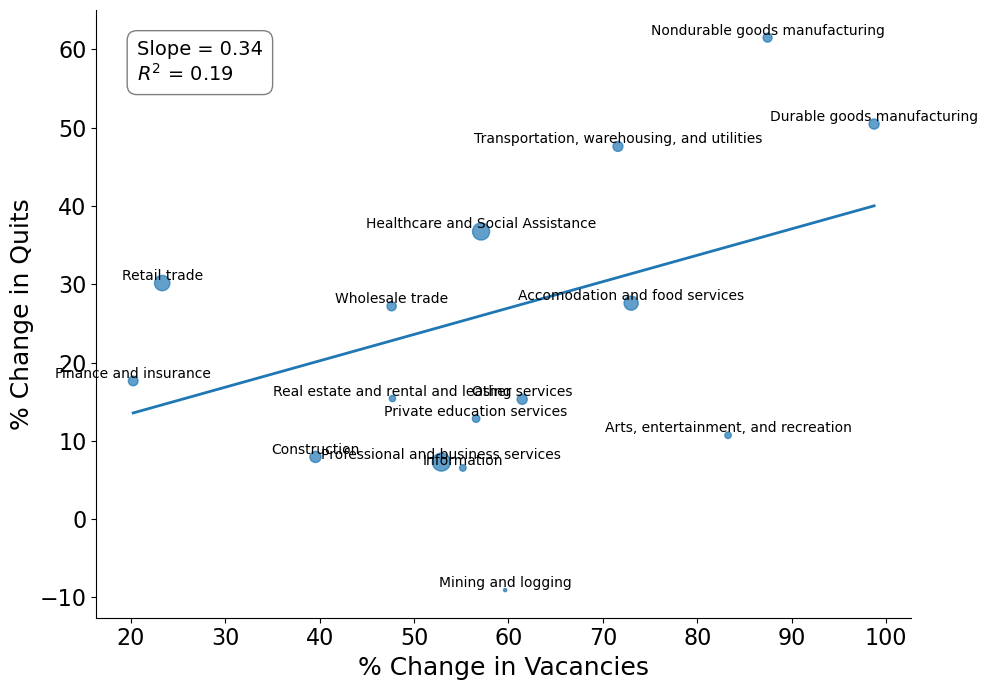

In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up variables
x = final_df["job_opening_pct_change"].to_numpy(dtype=float)
y = final_df["quits_pct_change"].to_numpy(dtype=float)
weights = final_df["emp_share"].to_numpy(dtype=float)
industries = final_df["jolts_industry"]

# Fit weighted linear regression
X = sm.add_constant(x)
model = sm.WLS(y, X, weights=weights).fit()

# Regression results
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared

print(f"Intercept: {intercept:.2f}")
print(f"Slope (coefficient on job openings): {slope:.2f}")
print(f"R-squared: {r_squared:.2f}")

# Predicted line
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(sm.add_constant(x_pred))

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x, y, s=weights * 1000, alpha=0.7)

# Add labels for each industry
for i in range(len(final_df)):
    plt.text(x[i], y[i], industries.iloc[i], fontsize=10, ha='center', va='bottom')

# Regression line
plt.plot(x_pred, y_pred, linewidth=2)

# Axis labels and title
plt.xlabel("% Change in Vacancies", fontsize=18)
plt.ylabel("% Change in Quits", fontsize = 18)
#plt.title("Industry-Level % Changes: Quits vs Vacancies", fontsize=22)



# Add regression info with slope first, then R²
plt.text(0.05, 0.95,
         f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         fontsize=14, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5))

# Remove top and right spines to make it less boxy
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)


plt.tight_layout()
plt.savefig(f"{output_dir}/industry_flows_scatter_emp_wgt.pdf")
plt.show()


Intercept: 10.22
Slope (coefficient on job openings): 0.27
R-squared: 0.13


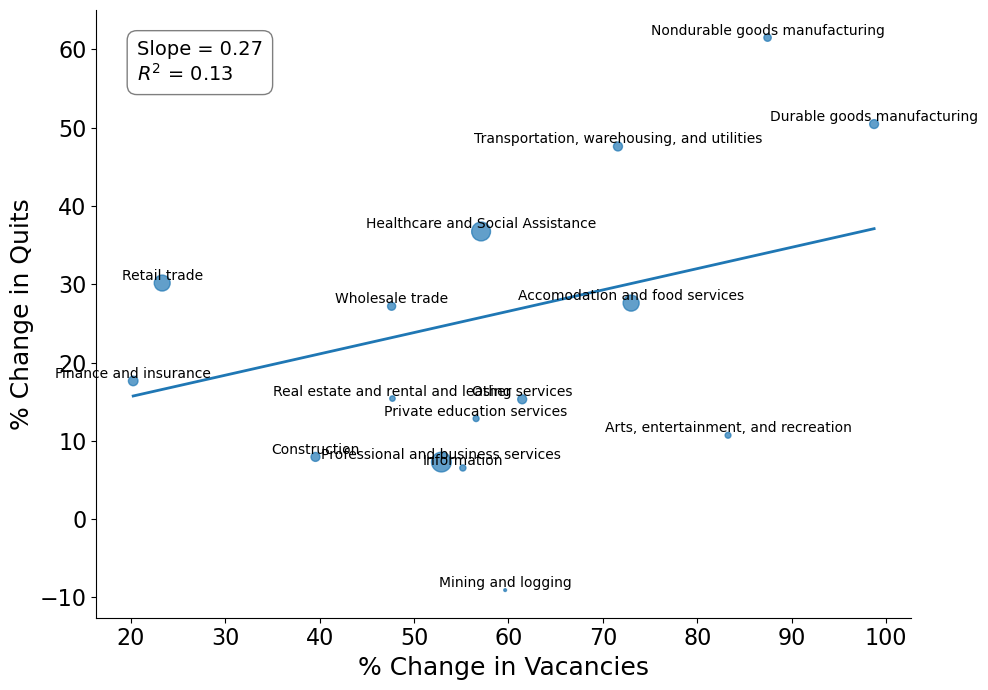

In [23]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up variables
x = final_df["job_opening_pct_change"].to_numpy(dtype=float)
y = final_df["quits_pct_change"].to_numpy(dtype=float)
weights = final_df["vac_share"].to_numpy(dtype=float)
industries = final_df["jolts_industry"]

# Fit weighted linear regression
X = sm.add_constant(x)
model = sm.WLS(y, X, weights=weights).fit()

# Regression results
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared

print(f"Intercept: {intercept:.2f}")
print(f"Slope (coefficient on job openings): {slope:.2f}")
print(f"R-squared: {r_squared:.2f}")

# Predicted line
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(sm.add_constant(x_pred))

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x, y, s=weights * 1000, alpha=0.7)

# Add labels for each industry
for i in range(len(final_df)):
    plt.text(x[i], y[i], industries.iloc[i], fontsize=10, ha='center', va='bottom')

# Regression line
plt.plot(x_pred, y_pred, linewidth=2)

# Axis labels and title
plt.xlabel("% Change in Vacancies", fontsize=18)
plt.ylabel("% Change in Quits", fontsize = 18)
#plt.title("Industry-Level % Changes: Quits vs Vacancies", fontsize=22)



# Add regression info with slope first, then R²
plt.text(0.05, 0.95,
         f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         fontsize=14, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5))

# Remove top and right spines to make it less boxy
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)


plt.tight_layout()
plt.savefig(f"{output_dir}/industry_flows_scatter_vac_wgt.pdf")
plt.show()


Intercept: 0.01
Slope (coefficient on job openings): 0.39
R-squared: 0.20


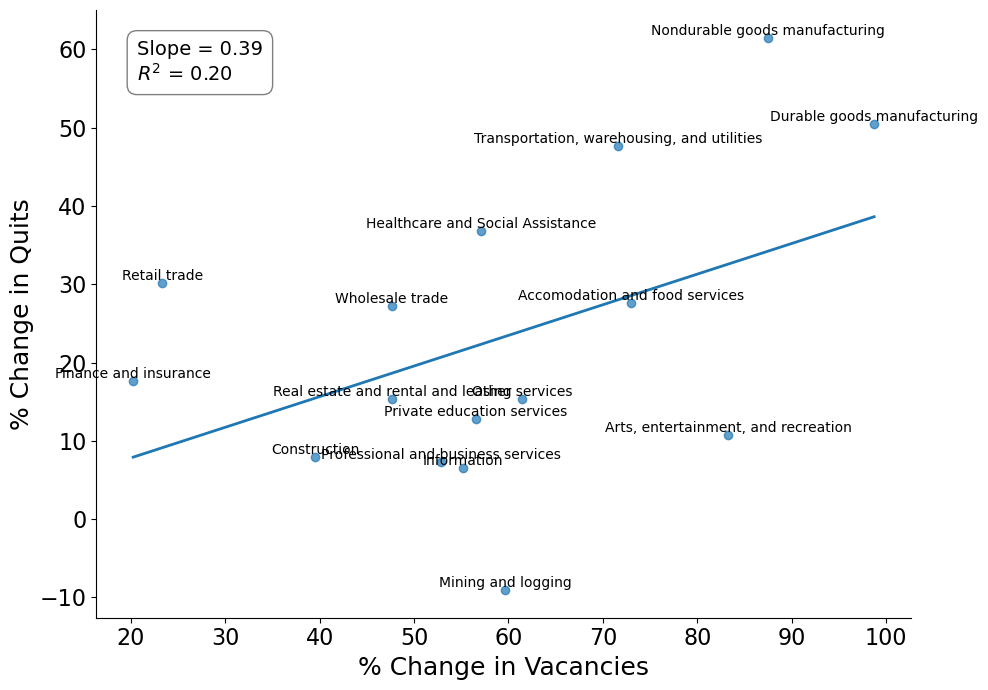

In [24]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up variables
x = final_df["job_opening_pct_change"].to_numpy(dtype=float)
y = final_df["quits_pct_change"].to_numpy(dtype=float)
weights = final_df["emp_share"].to_numpy(dtype=float)
industries = final_df["jolts_industry"]

# Fit weighted linear regression
X = sm.add_constant(x)
model = sm.WLS(y, X).fit()

# Regression results
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared

print(f"Intercept: {intercept:.2f}")
print(f"Slope (coefficient on job openings): {slope:.2f}")
print(f"R-squared: {r_squared:.2f}")

# Predicted line
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(sm.add_constant(x_pred))

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.7)

# Add labels for each industry
for i in range(len(final_df)):
    plt.text(x[i], y[i], industries.iloc[i], fontsize=10, ha='center', va='bottom')

# Regression line
plt.plot(x_pred, y_pred, linewidth=2)

# Axis labels and title
plt.xlabel("% Change in Vacancies", fontsize=18)
plt.ylabel("% Change in Quits", fontsize = 18)
#plt.title("Industry-Level % Changes: Quits vs Vacancies", fontsize=22)



# Add regression info with slope first, then R²
plt.text(0.05, 0.95,
         f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         fontsize=14, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5))

# Remove top and right spines to make it less boxy
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)


plt.tight_layout()
plt.savefig(f"{output_dir}/industry_flows_scatter_unwgt.pdf")
plt.show()
